In [ ]:
# library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url='/content/drive/MyDrive/datalanjutan.csv'

In [ ]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)
df = pd.read_csv(url)
df.head(3)

,Unnamed: 0,annual_inc,dti,total_acc,delinq_2yrs,acc_now_delinq,purpose,term,target
0,0,24000.0,27.65,9.0,0.0,0.0,1,36,1
1,1,30000.0,1.00,4.0,0.0,0.0,0,60,0
2,2,12252.0,8.72,10.0,0.0,0.0,11,36,1


In [ ]:
df.columns

Index(['Unnamed: 0', 'annual_inc', 'dti', 'total_acc', 'delinq_2yrs',
       'acc_now_delinq', 'purpose', 'term', 'target'],
      dtype='object')

In [ ]:
# Split data
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Unnamed: 0', 'target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# Normalisasi
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_res =  scaler.transform(X_train_res)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_classification(rf)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.88
Recall (Test Set): 0.98
F1-Score (Test Set): 0.93
roc_auc (test-proba): 0.54
roc_auc (train-proba): 1.00


#SMOTE sampling

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
eval_classification(rf)

Accuracy (Test Set): 0.77
Precision (Test Set): 0.88
Recall (Test Set): 0.85
F1-Score (Test Set): 0.87
roc_auc (test-proba): 0.53
roc_auc (train-proba): 1.00


#Hyperparameter Tuning

In [ ]:
# tuning hyperparameter RF + oversampling
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, hyperparameters, scoring='roc_auc', random_state=1, cv=5)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.88
Recall (Test Set): 1.00
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.61
roc_auc (train-proba): 0.63


param value: 2; train: 0.9971150967368254; test: 0.5536288262849065
param value: 3; train: 0.9882673553875576; test: 0.5623871150956699
param value: 4; train: 0.97605049374131; test: 0.5657259058867772
param value: 5; train: 0.9617038014777124; test: 0.5708583219507359
param value: 7; train: 0.9308838379559876; test: 0.5758276493482093
param value: 8; train: 0.9182274720489658; test: 0.5780908261717339
param value: 9; train: 0.9056843706699669; test: 0.5800671553306758
param value: 11; train: 0.8812095558039339; test: 0.583441862490212
param value: 12; train: 0.8698701570104375; test: 0.5844544696050316
param value: 13; train: 0.8604218853062366; test: 0.5840024310854555
param value: 14; train: 0.8506305774301317; test: 0.5863870919862968
param value: 16; train: 0.8335514061762487; test: 0.5883050440686518
param value: 17; train: 0.8261236373563579; test: 0.5890947484548978
param value: 18; train: 0.8180414331108743; test: 0.5910611537772688
param value: 20; train: 0.8057536829077319; 

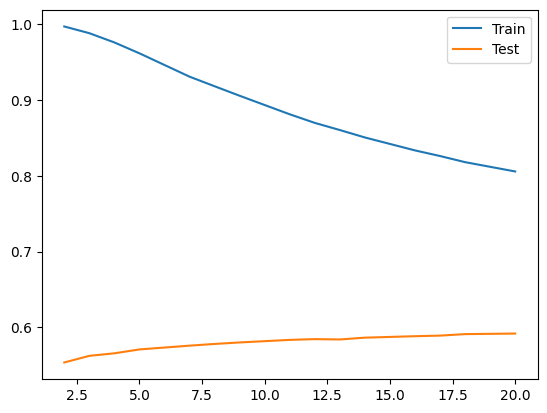

In [ ]:
#learning curve
# param_values = [int(x) for x in np.linspace(1, 200, 50)] # n_estimators
# param_values = [int(x) for x in np.linspace(2, 100, 50)] # max_depth
# param_values = [int(x) for x in np.linspace(2, 20, 15)] # min_samples_split
param_values = [int(x) for x in np.linspace(2, 20, 15)] # min_samples_leaf

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(n_estimators=75, min_samples_leaf=c)
    model.fit(X_train, y_train)

    # eval on train
    y_pred_train_proba = model.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # eval on test
    y_pred_proba = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()
plt.show()

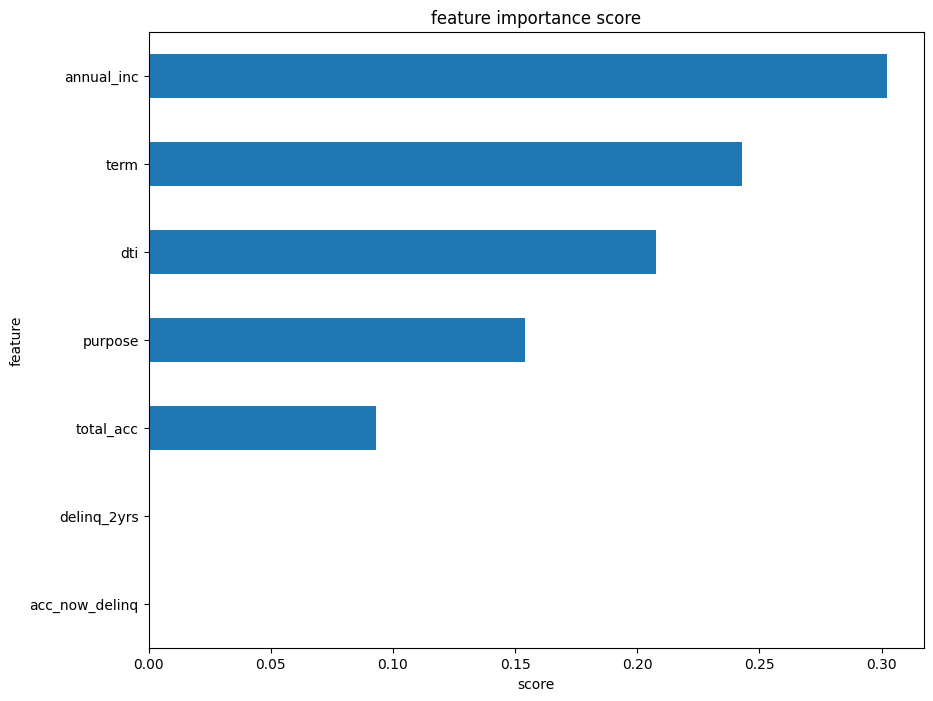

In [ ]:
show_feature_importance(rs.best_estimator_)